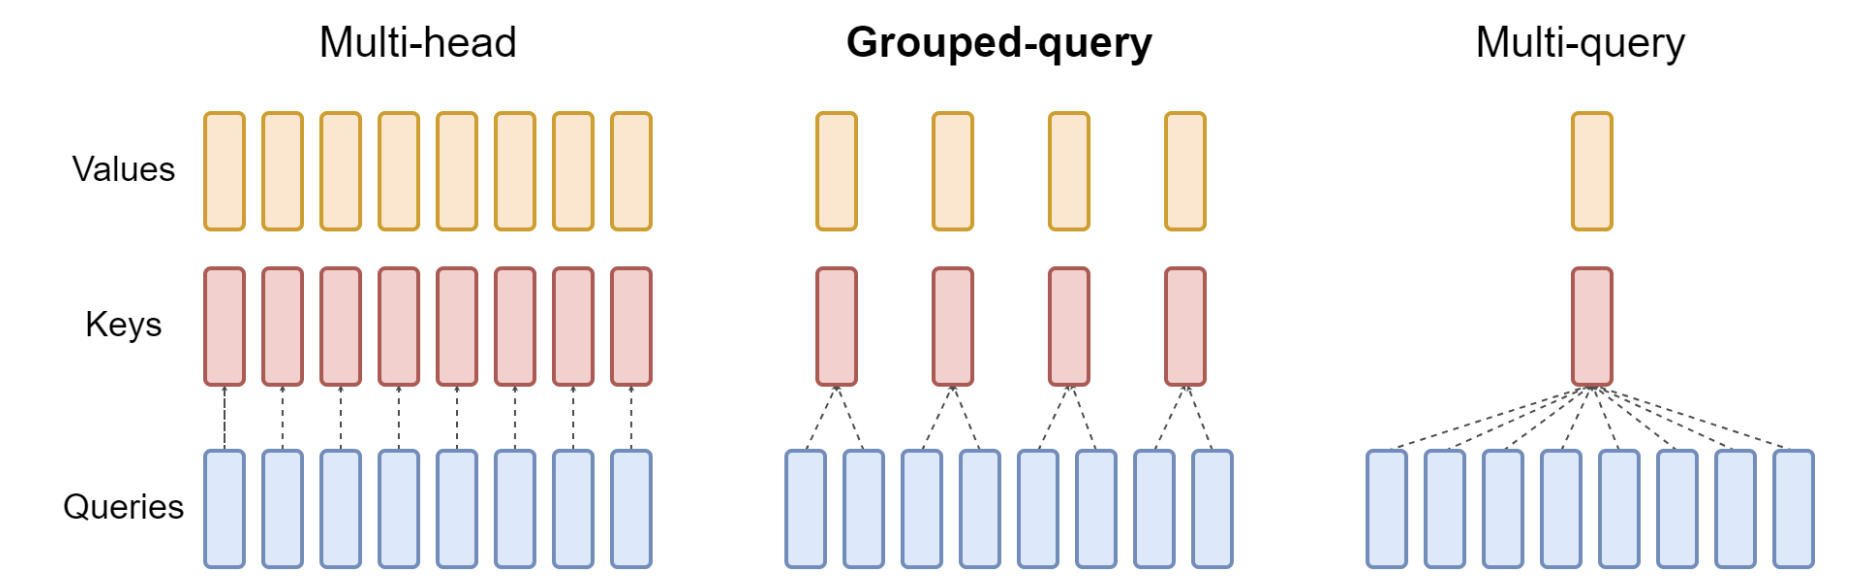

In [ ]:
import math
import torch
import torch.nn as nn

class GroupQueryAttention(nn.Module): # 当nums_key_value_head = 1时，变为MHA
    def __init__(self, hidden_dim, nums_head, nums_key_value_head) -> None:
        super().__init__()
        assert hidden_dim % nums_head == 0
        assert nums_head % nums_key_value_head == 0 # N个query为一组

        self.hidden_dim = hidden_dim
        self.nums_head = nums_head
        self.nums_key_value_head = nums_key_value_head
        self.head_dim = hidden_dim // nums_head

        # linear shape: (input_size, output_size)
        self.q_proj = nn.Linear(hidden_dim, nums_head * self.head_dim)
        self.k_proj = nn.Linear(hidden_dim, nums_key_value_head * self.head_dim)
        self.v_proj = nn.Linear(hidden_dim, nums_key_value_head * self.head_dim)
        self.o_proj = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, X, attention_mask = None):
        batch_size, seq_length, _ = X.size()

        q = self.q_proj(X).view(batch_size, seq_length, self.nums_head, self.head_dim).transpose(1, 2)
        k = self.k_proj(X).view(batch_size, seq_length, self.nums_key_value_head, self.head_dim).transpose(1, 2)
        v = self.v_proj(X).view(batch_size, seq_length, self.nums_key_value_head, self.head_dim).transpose(1, 2)
        # 得到shape: (b, nums_head, s, head_dim)
        k = k.repeat_interleave(self.nums_head // self.nums_key_value_head, dim=1)
        v = v.repeat_interleave(self.nums_head // self.nums_key_value_head, dim=1)
        
        attention_score = q @ k.transpose(2, 3) / math.sqrt(self.head_dim)
        attention_weight = torch.softmax(
            attention_score,
            dim=-1
        )

        output_mid = attention_weight @ v # (b, nums_head, s, head_dim)
        output_mid = output_mid.transpose(1, 2).contiguous() # (b, s, nums_head, head_dim)
        output = self.o_proj(output_mid.view(batch_size, seq_length, -1))
        return output
    
X = torch.rand(3, 2, 128)
net = GroupQueryAttention(128, 8, 4)
net(X)

tensor([[[-3.8737e-02,  3.2068e-01, -1.8946e-01,  4.1565e-02,  9.6772e-02,
          -3.8821e-02,  1.8216e-01, -3.6337e-02,  1.8612e-01,  3.3099e-01,
          -1.2257e-01, -8.1558e-02, -7.6947e-03, -9.8480e-02, -4.1823e-01,
          -2.4316e-01,  2.7902e-01, -1.6997e-01, -2.0198e-01,  1.7881e-01,
           9.0351e-02,  2.6337e-01,  1.2380e-01, -3.0573e-02,  1.9386e-02,
          -6.0716e-02, -1.5174e-02, -1.4335e-01,  1.2833e-01,  3.6499e-01,
           3.7302e-01,  3.0332e-02,  5.4851e-02, -3.0520e-03,  1.5319e-01,
           2.7630e-02, -9.6868e-02,  2.8820e-01,  1.5406e-01,  3.2052e-02,
           4.0315e-02, -8.5251e-02,  2.7288e-01, -7.6376e-02,  7.1216e-02,
           1.4374e-01, -4.0135e-02, -2.7633e-01, -1.2487e-01, -2.1266e-01,
          -2.5156e-01, -1.0133e-01,  2.3050e-01, -2.2891e-01, -1.0172e-01,
           3.9241e-01, -2.5381e-01, -5.6284e-02,  2.2684e-01,  1.3336e-01,
           1.0135e-01, -1.9923e-01,  6.9849e-02,  1.7393e-01, -1.1416e-01,
          -8.2338e-02,  2